In [1]:
from astropy.table import Table
from tqdm.notebook import tqdm
from types import SimpleNamespace
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import shutil
import subprocess

In [2]:
sys.path.append('/home/aalvarez/Work/Projects/Elements/5.8/InstallArea/x86_64-fc31-gcc92-dbg/python/')
sys.path.append('/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/NNPZ/python/')
os.environ['ELEMENTS_AUX_PATH'] = '/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/NNPZ/auxdir/'
os.environ['PATH'] = os.environ['PATH'] + ':/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/build.x86_64-fc31-gcc92-dbg/scripts/'

In [3]:
from nnpz.photometry import *
from nnpz.reference_sample.ReferenceSample import ReferenceSample
from nnpz.program import BuildPhotometry

# Reference and target samples

Got `NNPZ_filter_shift_valid_coherent_noiseless_max_photon.fits`, shuffled, took 400k sources for the reference and 100k for the target.

In [4]:
ref_catalog = Table.read('/home/aalvarez/Work/Data/WillHartley/ReferenceSubset.fits')
target_catalog = Table.read('/home/aalvarez/Work/Data/WillHartley/TargetSubset.fits')

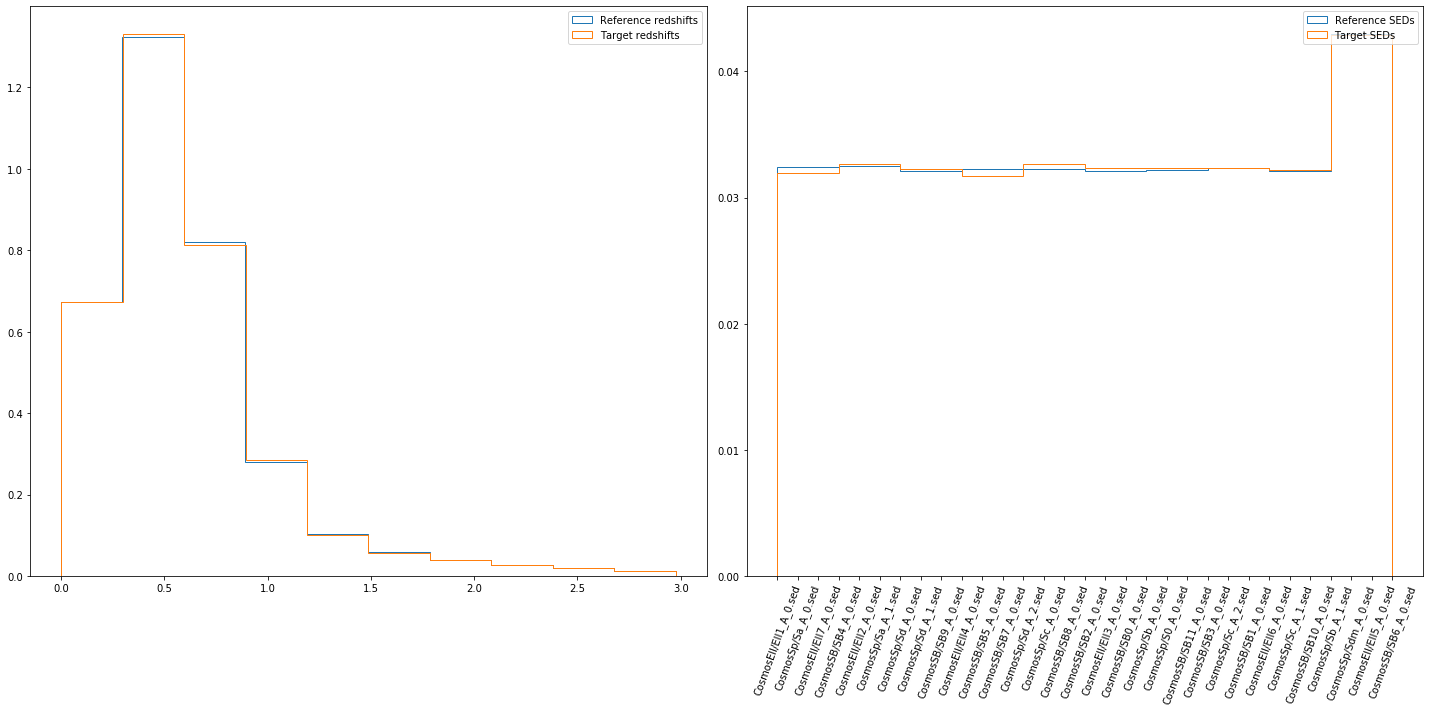

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(20,10))
axes[0].hist(ref_catalog['z'], label='Reference redshifts', histtype='step', density=True)
axes[0].hist(target_catalog['z'], label='Target redshifts', histtype='step', density=True)
axes[0].legend()
axes[1].hist(ref_catalog['SED_name'], label='Reference SEDs', histtype='step', density=True)
axes[1].hist(target_catalog['SED_name'], label='Target SEDs', histtype='step', density=True)
axes[1].tick_params(axis='x', rotation=70)
axes[1].legend()
plt.tight_layout()
plt.show()

In [6]:
np.intersect1d(ref_catalog['ID'], target_catalog['ID'])

array([], dtype=int64)

Both sets are disjoint, and have almost identical $N(z)$ and $N(SED)$

# Generate a reference sample for NNPZ

## Prepare the photometry computation

In [6]:
class SedProvider(object):
    def __init__(self, basedir):
        self.__basedir = basedir
        self.__cache = dict()
        
    def get_sed(self, name):
        if name not in self.__cache:
            self.__cache[name] = np.genfromtxt(os.path.join(self.__basedir, name))
        return self.__cache[name]

In [7]:
filter_provider = DirectoryFilterProvider('/home/aalvarez/Work/Data/WillHartley/DC3')
fnuu_prepost = FnuuJyPrePostProcessor()
sed_provider = SedProvider('/home/aalvarez/Phosphoros/AuxiliaryData/SEDs/')

In [8]:
transmissions = dict()
for filter_name in filter_provider.getFilterNames():
    print(f'Loading {filter_name}')
    transmissions[filter_name] = filter_provider.getFilterTransmission(filter_name)

Loading J
Loading r
Loading z
Loading g
Loading i
Loading Y
Loading u
Loading vis
Loading H


In [10]:
photo_calc = PhotometryCalculator(transmissions, fnuu_prepost)

In [11]:
for filter_name in transmissions.keys():
    ref_catalog[f'Flux_corrected_{filter_name}'] = ref_catalog[f'Flux_{filter_name}'] - ref_catalog[f'Fluxshift_{filter_name}']

In [12]:
def redshift_sed(row):
    original_sed = sed_provider.get_sed(row['SED_name'])
    sed = original_sed.copy()
    sed[:, 0] *= (1 + row['z'])
    sed[:, 1] /= (1 + row['z'])**2
    return sed
    
def compute_photometry(row):
    sed = redshift_sed(row)
    # Compute "raw" photometries
    fluxes = photo_calc.compute(sed)
    # Compute scale factor using i band
    scale_factor = row['Flux_corrected_i'] / fluxes['i']
    sed[:, 1] *= scale_factor        
    # Recompute with the scaled SED
    fluxes = photo_calc.compute(sed)
    return sed, fluxes, scale_factor

In [9]:
sample = ref_catalog[:]
sample = sample[np.argsort(sample['ID'])]

dtype=[]
for filter_name in transmissions.keys():
    dtype.append((filter_name, '>f4'))
all_photometries = np.zeros((len(sample),), dtype=dtype)
scale = np.zeros((len(sample),))
diff = np.zeros(all_photometries.shape, dtype=all_photometries.dtype)
seds = dict()

In [14]:
for i in tqdm(range(len(sample))):
    sed, photo, scale[i] = compute_photometry(sample[i])
    seds[sample['ID'][i]] = sed
    for filter_name in photo:
        all_photometries[filter_name][i] = photo[filter_name]
        diff[filter_name][i] = all_photometries[filter_name][i] - sample[f'Flux_corrected_{filter_name}'][i]

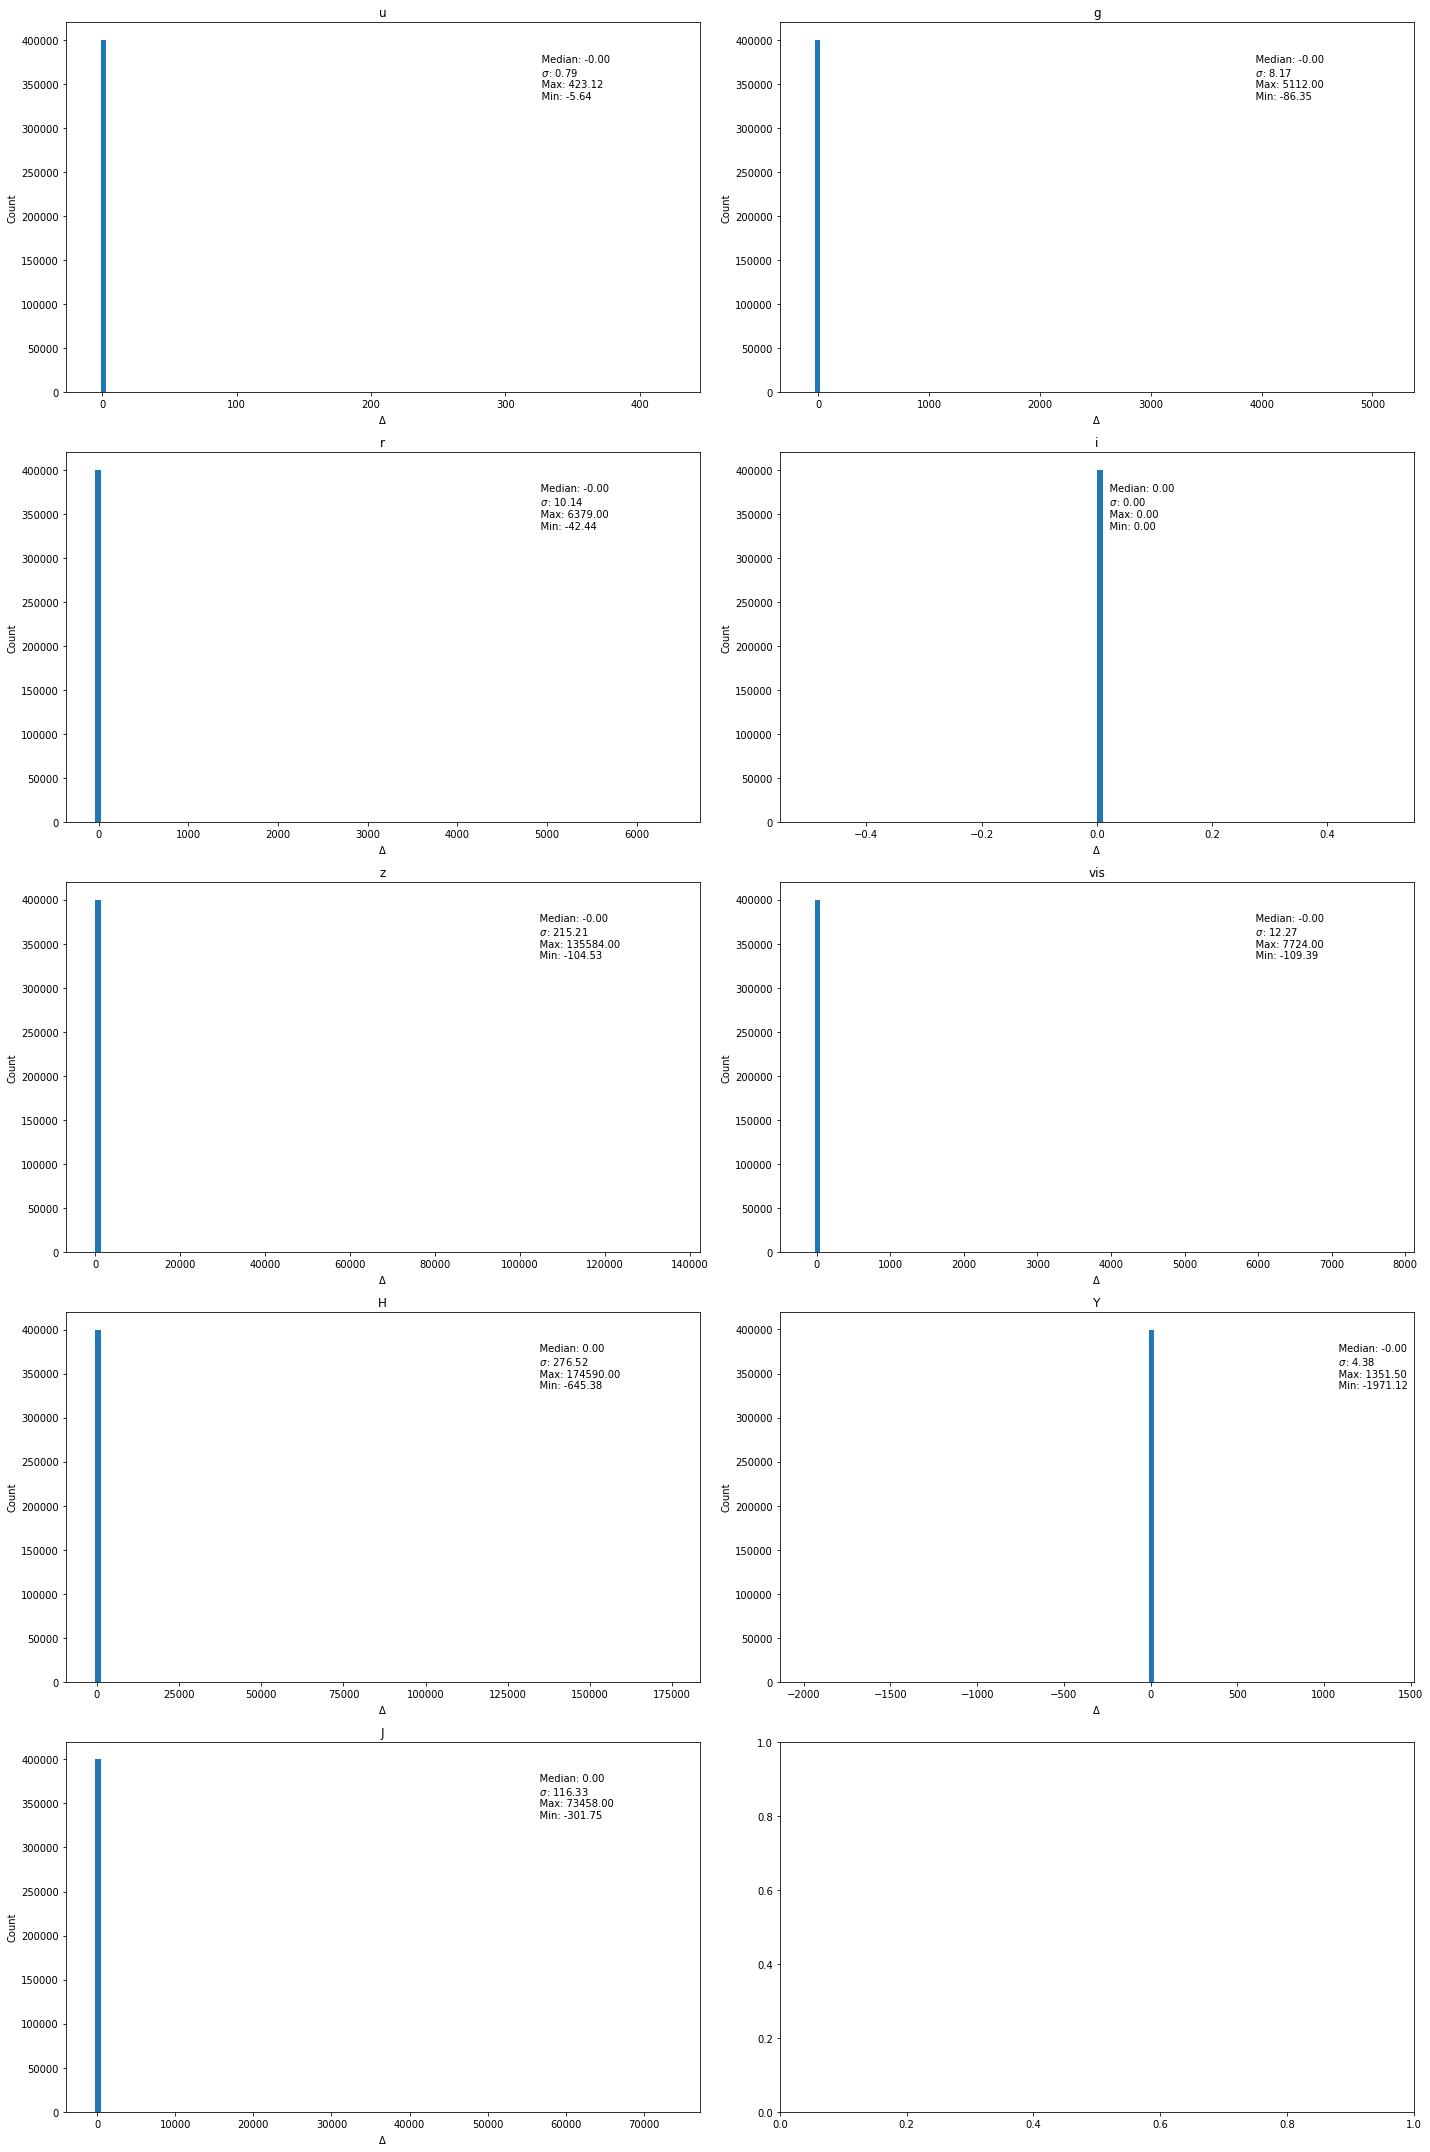

In [15]:
nfilters = len(all_photometries.dtype.names)
ncols = 2
nrows = int(np.ceil(nfilters / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 30))
axes = axes.ravel()

for i, filter_name in enumerate(['u', 'g', 'r', 'i', 'z', 'vis', 'H', 'Y', 'J']):
    ax = axes[i]
    counts, _, _ = ax.hist(diff[filter_name], bins=100)
    ax.text(diff[filter_name].max()*0.75, np.max(counts)*0.80, f"""
    Median: {np.median(diff[filter_name]):.2f}
    $\sigma$: {np.std(diff[filter_name]):.2f}
    Max: {np.max(diff[filter_name]):.2f}
    Min: {np.min(diff[filter_name]):.2f}
    """)
    ax.set_title(filter_name)
    ax.set_xlabel('$\Delta$')
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

# Build the reference sample

In [16]:
reference_dir = '/home/aalvarez/Work/Data/WillHartley/ReferenceSample'

In [17]:
pdz_bins = np.arange(0.01, 6.01, 0.01)
pdz_bin_edges = np.arange(-0.005, 6.005, 0.01)

In [18]:
shutil.rmtree(reference_dir, ignore_errors=True)
ref_sample = ReferenceSample.createNew(reference_dir)

for i in tqdm(range(len(sample))):
    row = sample[i]
    
    pdz, _ = np.histogram([row['z']], bins=pdz_bin_edges)
    
    ref_sample.createObject(row['ID'])
    ref_sample.addSedData(row['ID'], seds[row['ID']])
    ref_sample.addPdzData(row['ID'], np.stack([pdz_bins, pdz]).T)

NnpzBuildPhotometry --sample-dir ReferenceSample --out-type F_nu_uJy --out-file Photometry.fits --filters ~/Work/Data/WillHartley/DC3 --parallel 4

# Sanity check

In [10]:
ref2 = ReferenceSample('/home/aalvarez/Work/Data/WillHartley/ReferenceSample/')

In [11]:
for refid in ref2.getIds():
    refsed = ref2.getSedData(refid)
    sed = seds[refid]
    assert np.isclose(sed[:,0], refsed[:,0]).all()
    assert np.isclose(sed[:,1], refsed[:,1]).all()

KeyError: 0

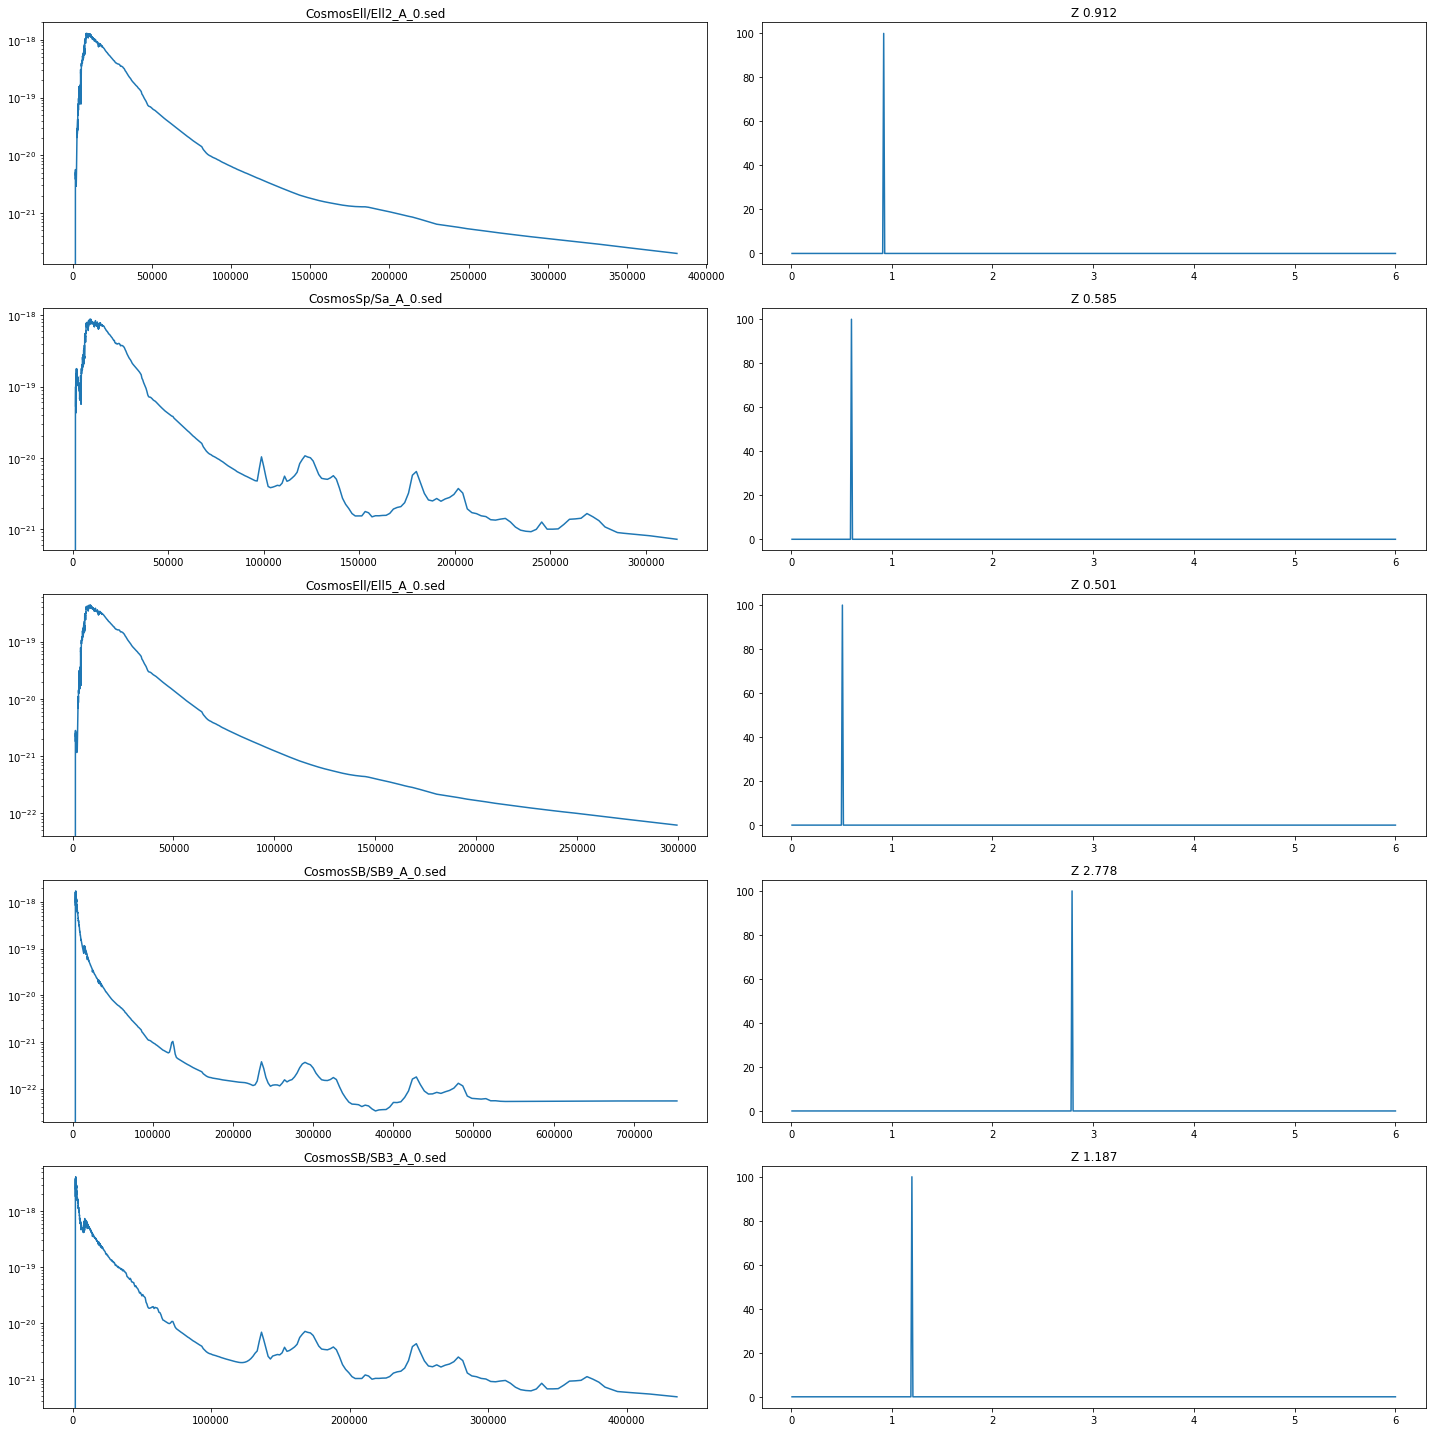

In [13]:
fig, axes = plt.subplots(ncols = 2, nrows=5, figsize=(20, 20))
ids = np.random.choice(sample[sample['z']>0.5]['ID'], axes.shape[0])
for i, srcid in enumerate(ids):
    srcsed = ref2.getSedData(srcid)
    srcpdz = ref2.getPdzData(srcid)
    src = sample[sample['ID'] == srcid][0]
    axes[i, 0].plot(srcsed[:,0], srcsed[:,1])
    axes[i, 0].set_yscale('log')
    axes[i, 0].set_title(f'{src["SED_name"]}')
    axes[i, 1].plot(srcpdz[:,0], srcpdz[:,1])
    axes[i, 1].set_title(f'Z {src["z"]:.3f}')
plt.tight_layout()
plt.show()

In [14]:
photometry = Table.read('/home/aalvarez/Work/Data/WillHartley/Photometry.fits', hdu=1)
photometry = photometry[np.argsort(photometry['ID'])]

assert (photometry['ID'] == sample['ID']).all()

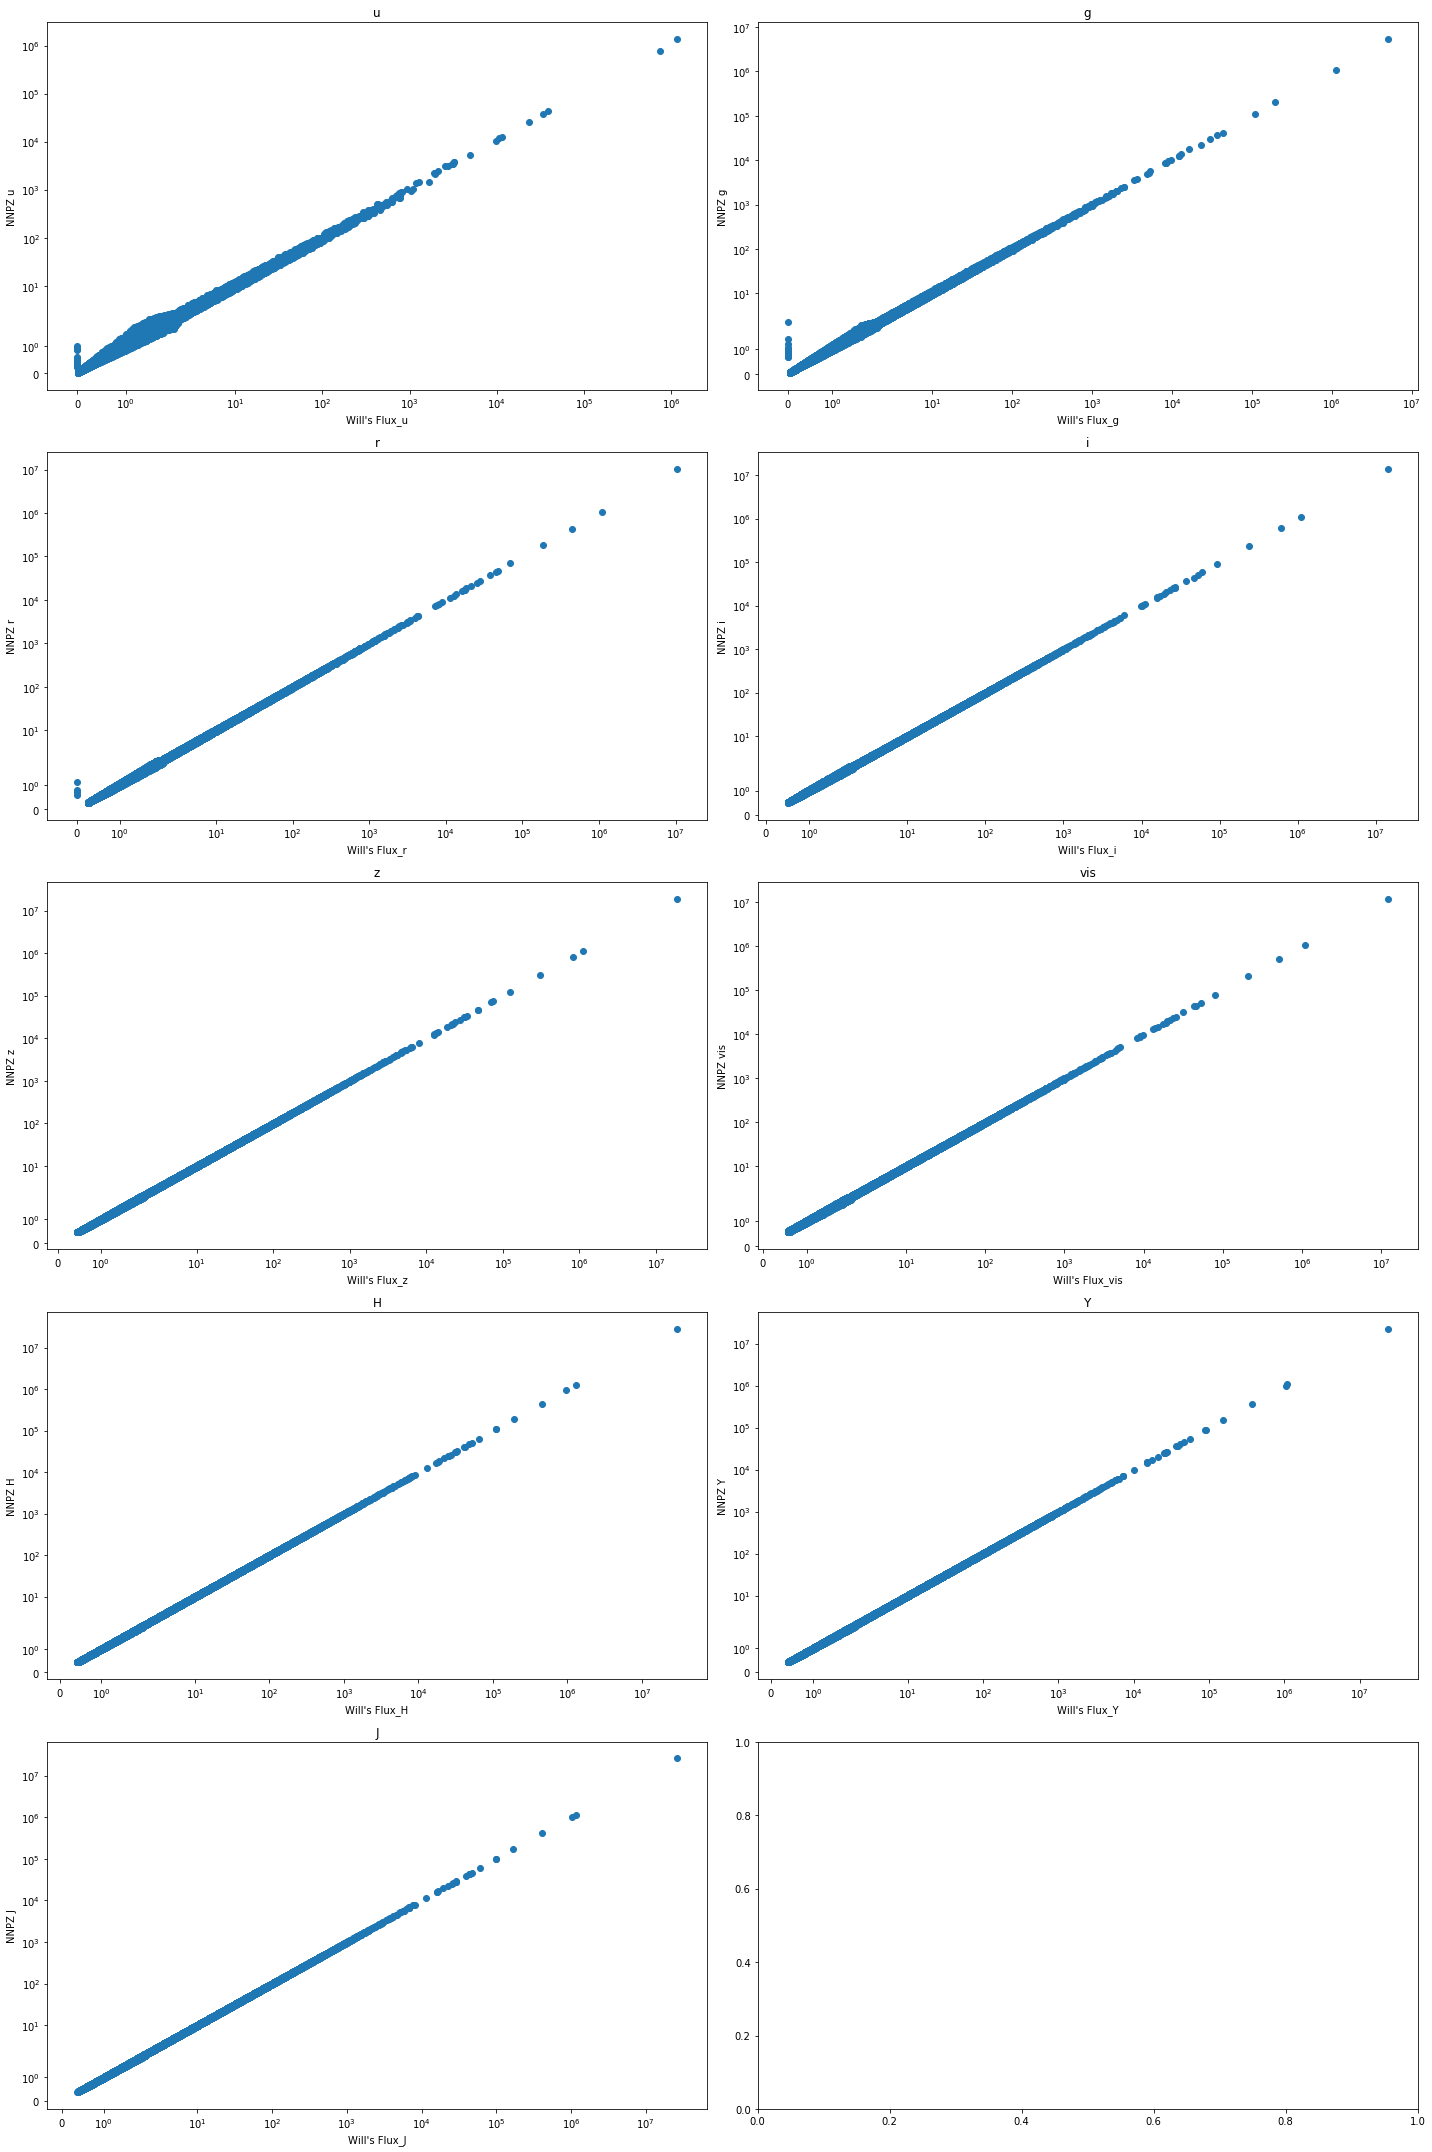

In [16]:
nfilters = len(all_photometries.dtype.names)
ncols = 2
nrows = int(np.ceil(nfilters / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 30))
axes = axes.ravel()

for i, filter_name in enumerate(['u', 'g', 'r', 'i', 'z', 'vis', 'H', 'Y', 'J']):
    ax = axes[i]
    wfn = f'Flux_{filter_name}'
    ax.scatter(sample[wfn], photometry[filter_name])
    ax.set_title(filter_name)
    ax.set_xlabel(f'Will\'s {wfn}')
    ax.set_ylabel(f'NNPZ {filter_name}')
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
plt.tight_layout()
plt.show()